In [1]:
!pip install scikit-image
!pip install imagecodecs
!pip install proplot
!pip install matplotlib==3.3.1
!pip install rioxarray

In [2]:
import sys 
import os
import numpy as np
from copy import deepcopy 
from PIL import Image
from matplotlib import pyplot as plt
!pip install tensorflow==2.7.0
!pip install -r requirements.txt

In [3]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
# import os
# import shutil
# import numpy as np
# import tensorflow as tf

# # Import modules from lib directory
# from lib.STpconvLayer import STpconv
# from lib.STpconvUnet import STpconvUnet
# from lib.DataGenerator import DataGenerator

# print("Using TensorFlow version", tf.__version__)

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# # Hyperparameters and other options
# BATCH_SIZE = 2 
# N_EPOCHS = 50 
# OUT_PATH = os.getcwd()
# DATA_PATH_TRAINING = "data/training"
# DATA_PATH_VALIDATION = "data/validation"

# N_CONV_LAYERS = 2
# N_CONV_PER_BLOCK = 1
# KERNEL_SIZES = [(3, 3, 3), (3, 3, 3)]
# N_FILTERS    = [16, 16]
# STRIDES = [(2, 2, 2),(2, 2, 2)]


# trn_generator = DataGenerator(DATA_PATH_TRAINING, batch_size = BATCH_SIZE)
# val_generator = DataGenerator(DATA_PATH_VALIDATION, batch_size = BATCH_SIZE)

# model = STpconvUnet(n_conv_layers = N_CONV_LAYERS, nx=128, ny=128, nt=16, kernel_sizes = KERNEL_SIZES, \
#                     n_filters = N_FILTERS, learning_rate=0.01, n_conv_per_block=N_CONV_PER_BLOCK, strides = STRIDES)
# model.summary()

# # save model at the end of each epoch
# checkpoint_dir = os.path.join(OUT_PATH, "out")
# if os.path.exists(checkpoint_dir):
#     shutil.rmtree(checkpoint_dir)
# os.mkdir(checkpoint_dir)
# checkpoint_filepath = os.path.join(checkpoint_dir, "epoch_{epoch:02d}.h5")
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath = checkpoint_filepath,
#     save_weights_only = True,
#     save_freq = "epoch",
#     save_best_only=False)

# # save hyperparameters in a JSON file
# model.save(os.path.join(OUT_PATH,"model_architecture"), save_weights = False)

# # train model
# history = model.model.fit(x=trn_generator, validation_data = val_generator, 
#                           epochs = N_EPOCHS, callbacks=[model_checkpoint_callback])

In [5]:
#tf.test.is_gpu_available()

NameError: name 'tf' is not defined

(113, 825, 200)
113


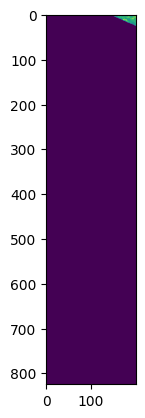

In [6]:
radar_arr = np.load("../input_arr.npy")
print(radar_arr.shape)
print(radar_arr.shape[0])
plt.figure()
plt.imshow(radar_arr[10,:,:])

In [7]:
def prepare_input(in_image):
    image_compressed = []
    image = deepcopy(in_image)
    min_dim = min((image.shape[1], image.shape[2]))
    image = image[:, :min_dim, :min_dim]
    for chunk in image:
        im = Image.fromarray(chunk)
        im.thumbnail((128, 128))
        image_compressed.append(np.array(im))
    image_compressed = np.array(image_compressed)
    image_compressed = np.transpose(image_compressed, axes=[1,2,0])
    mask = np.ones((128, 128, 16))
    mask[image_compressed<=0.01] = 0
    return image_compressed, mask

(128, 128, 16)


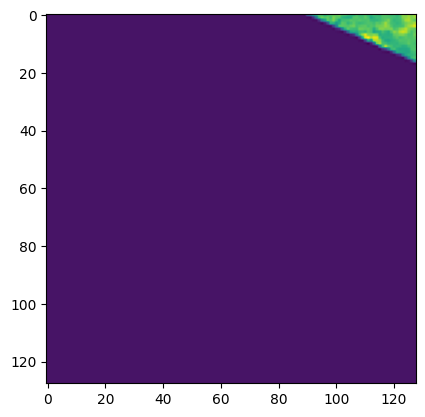

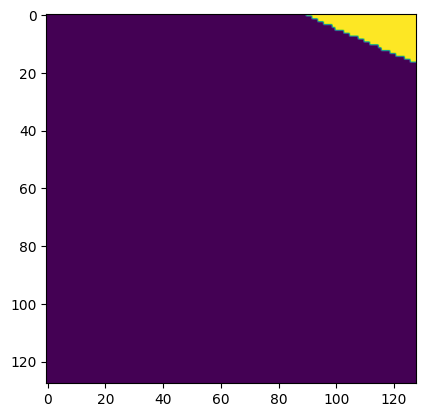

In [8]:
a = radar_arr[0:16,:,:]
im_compr, mask = prepare_input(a)
print(im_compr.shape)
plt.figure()
plt.imshow(im_compr[:,:,10])
plt.figure()
plt.imshow(mask[:,:,10])

In [9]:
def predict_single(image, mask):
    temp = image
    temp = np.expand_dims(temp, axis=0) # append "sample" dimension
    temp = np.expand_dims(temp, axis=4) # append "channel" dimension
    temp[temp<0] = 0 
    X = temp 
    #print('x_files shape', X.shape)
    temp = mask
    temp = np.expand_dims(temp, axis=0) # append "sample" dimension
    temp = np.expand_dims(temp, axis=4) # append "channel" dimension
    mask = temp
    #print('mask_files shape', mask.shape)
    
    pred = model.predict([X,mask, mask]) # 2nd mask is not needed here, so we simply use the same mask
    
    # create output file and copy spatial reference from input
    # img = rio.open(img_path)
    # crs = None
    # affine = None
    # if not img.crs is None:
    #     crs = img.crs.to_string()
    # if not img.transform is None:
    #     affine = img.transform
    # new_dataset = rio.open(out_path, 'w',driver='GTiff', height=pred.shape[1],
    #                        width=pred.shape[2],count=pred.shape[3], dtype=pred.dtype, crs=crs, transform=affine)
    # for it in range(model.nt):
    #     new_dataset.write(pred[0,:,:,it,0], it +1)
    # new_dataset.close()
    # img.close()
    return pred

In [10]:
import os
import sys
import numpy as np
import rasterio as rio
import time
import tensorflow as tf

from skimage import io as skio
from skimage import util as skutil

# Import modules from lib/ directory
from lib.STpconvLayer import STpconv
from lib.STpconvUnet import STpconvUnet
from lib.DataGenerator import DataGenerator

## uncomment for computation time measurements
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)


model = STpconvUnet.load("models/S5P_CO_model", weights_name = "models/S5P_CO_model.h5")

#assert len(mask_files) == len(x_files)


#start = time.process_time()
x_arr = [];
pred_arr = [];
for i in range(radar_arr.shape[0]-16):
    #print('type i:', type(i))
    #print('type radar_arr:', type(radar_arr))
    image = radar_arr[i:i+16,:,:]
    x, mask = prepare_input(image)
    pred = predict_single(x, mask)
    mask2 = np.ones((np.size(mask,axis=0), np.size(mask,axis=1), np.size(mask,axis=2)))-mask
    pred = np.squeeze(pred)
    pred = pred*mask2 + x
    x_arr.append(x)
    pred_arr.append(pred)
#t = time.process_time() - start   

print("DONE.")

2023-07-27 09:32:02.191605: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 09:32:03.115830: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-27 09:32:03.115907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30986 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:b9:00.0, compute capability: 7.0
2023-07-27 09:32:05.587302: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8500


DONE.


(97, 128, 128, 16)
(97, 128, 128, 16)


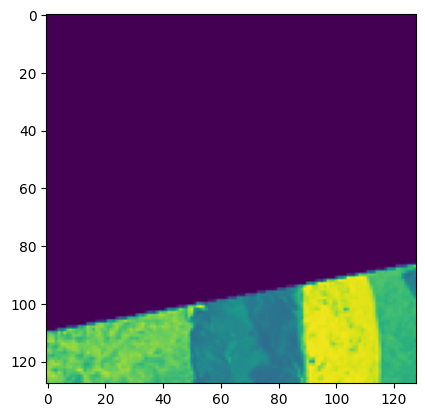

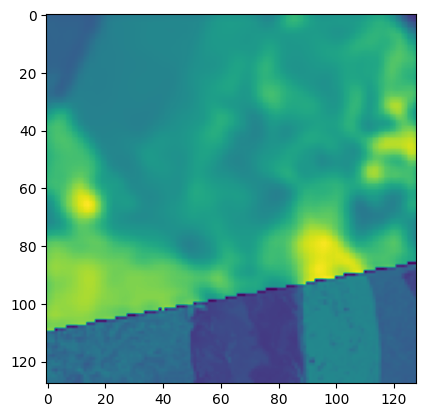

In [11]:
n = 1
t = 6
x_arr = np.array(x_arr)
pred_arr = np.array(pred_arr)
pred_arr = np.squeeze(pred_arr)
print(pred_arr.shape)
print(x_arr.shape)

plt.figure()
plt.imshow(x_arr[t,:,:,n])

plt.figure()
plt.imshow(pred_arr[t,:,:,n])


In [12]:
np.save("../preds/pred_arr_STpconv.npy", pred_arr)
np.save("../preds/x_arr_STpconv.npy", x_arr)
print('THAT IS ALL')

THAT IS ALL
